# Simple ver

In [1]:
!pip install d2l

     |████████████████████████████████| 83 kB 2.3 MB/s 


In [2]:
import random 
import torch
from d2l import torch as d2l

In [3]:
# generate the dataset 
def synthetic_data(weight,bias,num_examples):
  """ weight is vector of size (n,) and bias is a number 
  """
  X = torch.normal(0,1,(num_examples,len(weight))) # generate X with shape ()
  Y = torch.matmul(X,weight) + bias 
  Y += torch.normal(0,0.001,(num_examples,))
  return X,Y.reshape((-1,1))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.3881, 0.2659]) 
label: tensor([6.0711])


In [6]:
features.shape[0]

1000

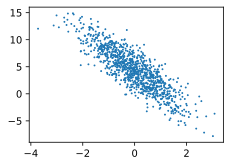

In [7]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

In [8]:
# data loader 
def data_loader(batch_size,features,labels):
  num_examples = features.shape[0]
  indicies = list(range(num_examples))
  random.shuffle(indicies)
  for i in range(0,num_examples,batch_size):
    batch_indicies = torch.tensor(indicies[i : min(i + batch_size, num_examples)])
    yield features[batch_indicies],labels[batch_indicies]

In [9]:
batch_size = 10

for X, y in data_loader(batch_size, features, labels):
    print(X, '\n', y)
    print(X.shape, '\n', y.shape)
    break

tensor([[ 0.8491,  1.1865],
        [ 0.2561, -1.0804],
        [-0.2384, -0.1362],
        [ 0.4784, -0.1690],
        [-0.1075, -1.3638],
        [ 0.0032, -0.0641],
        [ 1.1063, -0.9292],
        [ 1.8284,  1.9692],
        [ 1.2137,  0.8724],
        [ 0.3318, -0.5287]]) 
 tensor([[1.8648],
        [8.3830],
        [4.1850],
        [5.7315],
        [8.6213],
        [4.4256],
        [9.5714],
        [1.1638],
        [3.6622],
        [6.6598]])
torch.Size([10, 2]) 
 torch.Size([10, 1])


In [10]:
# initialize model params 
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [11]:
# model
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b


In [12]:
# loss
def sqr_loss(y_hat,y):
  return (y_hat - y.reshape(y_hat.shape))**2/2

In [13]:
# optimization 
def sgd(params,lr,batch_size):
  with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = sqr_loss

for epoch in range(num_epochs):
    for X, y in data_loader(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.027914
epoch 2, loss 0.000046
epoch 3, loss 0.000001


In [15]:
w 

tensor([[ 1.9998],
        [-3.3997]], requires_grad=True)

In [16]:
b

tensor([4.1997], requires_grad=True)

In [17]:
net(features[0],w,b)

tensor([6.0717], grad_fn=<AddBackward0>)

In [18]:
labels[0]

tensor([6.0711])

In [19]:
loss(net(features[0],w,b),labels[0])

tensor([1.3907e-07], grad_fn=<DivBackward0>)

# Concise ver 

In [20]:
import numpy as np 
from torch.utils import data 

true_w = torch.tensor([3.2,2.4])
true_b = torch.tensor([2.7])
features,labels = synthetic_data(true_w,true_b,1000)

In [22]:
features.shape

torch.Size([1000, 2])

In [28]:
#data loader ver real 

def load_data(features,label, batch_size, for_train = False):
  """construct a torch data iterator  """
  dataset = data.TensorDataset(*(features,label))
  return data.DataLoader(dataset,batch_size,shuffle= for_train)

In [30]:
batch_size = 10
data_iter = load_data(features, labels, batch_size,for_train = True)

In [34]:
features.shape

torch.Size([1000, 2])

In [35]:
labels.shape

torch.Size([1000, 1])

In [31]:
next(iter(data_iter))

[tensor([[-1.0809, -0.6335],
         [ 0.6330, -0.1810],
         [ 0.2855, -0.1181],
         [ 0.5743,  1.1170],
         [ 0.2993, -0.8032],
         [-0.0925, -1.4491],
         [-0.5539, -0.5787],
         [-1.0012, -0.2688],
         [ 0.4247,  0.0990],
         [ 1.1907, -1.8153]]), tensor([[-2.2797],
         [ 4.2903],
         [ 3.3318],
         [ 7.2172],
         [ 1.7295],
         [-1.0732],
         [-0.4615],
         [-1.1489],
         [ 4.2957],
         [ 2.1535]])]

In [36]:
# define model 
from torch import nn 
model = nn.Sequential(nn.Linear(features.shape[1],labels.shape[1]))

In [43]:
# initialize the parameters 
model[0].weight.data.normal_(0,0.01)
model[0].bias.data.fill_(0)

tensor([0.])

In [44]:
# loss function 
loss = nn.MSELoss()

In [46]:
# trainer
trainer = torch.optim.SGD(model.parameters(),lr = 0.03)

In [48]:
# Training 
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(model(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(model(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000059
epoch 2, loss 0.000001
epoch 3, loss 0.000001


In [50]:
w = model[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = model[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-3.4571e-05, -2.2650e-05])
error in estimating b: tensor([2.8610e-05])
